# CMPS 320 Final Project - Divorce Dataset Analysis

## TODO:

- modify code slightly; variable names, code structure, etc (X)
- change results in slides (or in report?) to graph form
- cross validation
- adding narrative behind the remainder of the ipynb

## Importing packages

In [463]:
# imports
import warnings
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, accuracy_score, plot_roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline

from sklearn import decomposition
from sklearn import preprocessing
from sklearn import metrics

import shap


%matplotlib inline
plt.style.use('seaborn-white')

warnings.filterwarnings('ignore')

## Loading, cleaning, and exploring dataset

Our report aims to focus itself around the `Divorce Predictors` dataset. The dataset itself consists of data coming from 150 Turkish couples; 84 divorced, and 86 currently married, who completed an assessment aimed at getting a basic understanding of the couple, and their relationship. The data has 170 instances, containing 54 predictors in the form of a written question. These predictors are then divided into a 0-5 scale (inclusive), with:


+ 0 = Never
+ 1 = Seldom
+ 2 = Averagely
+ 3 = Frequently
+ 4 = Always

In [464]:
divorces = pd.read_csv('divorce.csv', delimiter=';')
divorces = divorces.sample(frac=1, random_state=42)

divorces.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q46,Q47,Q48,Q49,Q50,Q51,Q52,Q53,Q54,Divorce
139,3,1,1,0,0,0,0,0,0,0,...,3,2,2,0,2,2,0,0,4,0
30,3,4,3,2,3,0,1,4,3,2,...,4,4,4,4,4,4,4,4,4,1
119,0,1,1,0,0,2,0,0,0,0,...,2,2,2,0,2,1,1,1,0,0
29,4,3,3,2,4,1,0,3,3,2,...,4,4,4,4,4,4,4,4,4,1
144,0,0,2,4,0,0,0,0,0,2,...,2,0,2,4,0,0,1,0,0,0


Here, you may notice that we are manipulating our dataframe to exist in a sampled state. If you observe the CSV file that contains our dataframe, you may see an issue with the way that each couple is inserted into the CSV; they are entered based on their marital status, which naturally groups our married and non married couples together, which we want to do on our own. If we attempted to visualize our data without sampling, it might also be harder for us to simply interpret our findings.

In [465]:
# hide this
questionSet= [
    '1 If one of us apologizes when our discussion deteriorates, the discussion ends.',
    '2 I know we can ignore our differences, even if things get hard sometimes.',
    '3 When we need it, we can take our discussions with my spouse from the beginning and correct it.',
    '4 When I discuss with my spouse, to contact him will eventually work.',
    '5 The time I spent with my wife is special for us.',
    '6 We don\'t have time at home as partners.',
    '7 We are like two strangers who share the same environment at home rather than family.',
    '8 I enjoy our holidays with my wife.',
    '9 I enjoy traveling with my wife.',
    '10 Most of our goals are common to my spouse.',
    '11 I think that one day in the future, when I look back, I see that my spouse and I have been in harmony with each other.',
    '12 My spouse and I have similar values in terms of personal freedom.',
    '13 My spouse and I have similar sense of entertainment.',
    '14 Most of our goals for people (children, friends, etc) are the same.',
    '15 Our dreams with my spouse are similar and harmonious.',
    '16 We\'re compatible with my spouse about what love should be.',
    '17 We share the same views about being happy in our life with my spouse.',
    '18 My spouse and I have similar ideas about how marriage should be.',
    '19 My spouse and I have similar ideas about how roles should be in marriage.',
    '20 My spouse and I have similar values in trust.',
    '21 I know exactly what my wife likes.',
    '22 I know how my spouse wants to be taken care of when she/he sick.',
    '23 I know my spouse\'s favorite food.',
    '24 I can tell you what kind of stress my spouse is facing in her/his life.',
    '25 I have knowledge of my spouse\'s inner world.',
    '26 I know my spouse\'s basic anxieties.',
    '27 I know what my spouse\'s current sources of stress are.',
    '28 I know my spouse\'s hopes and wishes.',
    '29 I know my spouse very well.',
    '30 I know my spouse\'s friends and their social relationships.',
    '31 I feel aggressive when I argue with my spouse.',
    "32 When discussing with my spouse, I usually use expressions such as 'you always' or 'you never'.",
    '33 I can use negative statements about my spouse\'s personality during our discussions.',
    '34 I can use offensive expressions during our discussions.',
    '35 I can insult my spouse during our discussions.',
    '36 I can be humiliating when we discussions.',
    '37 My discussion with my spouse is not calm.',
    '38 I hate my spouse\'s way of open a subject.',
    '39 Our discussions often occur suddenly.',
    '40 We\'re just starting a discussion before I know what\'s going on.',
    '41 When I talk to my spouse about something, my calm suddenly breaks.',
    '42 When I argue with my spouse, I only go out and I don\'t say a word.',
    '43 I mostly stay silent to calm the environment a little bit.',
    '44 Sometimes I think it\'s good for me to leave home for a while.',
    '45 I\'d rather stay silent than discuss with my spouse.',
    '46 Even if I\'m right in the discussion, I stay silent to hurt my spouse.',
    '47 When I discuss with my spouse, I stay silent because I am afraid of not being able to control my anger.',
    '48 I feel right in our discussions.',
    '49 I have nothing to do with what I\'ve been accused of.',
    '50 I\'m not actually the one who\'s guilty about what I\'m accused of.',
    '51 I\'m not the one who\'s wrong about problems at home.',
    '52 I wouldn\'t hesitate to tell my spouse about her/his inadequacy.',
    '53 When I discuss, I remind my spouse of her/his inadequacy.',
    '54 I\'m not afraid to tell my spouse about her/his incompetence.'
]

The following questions are predictors in our dataframe that we will be using to attempt to predict the marital status of a couple. We have formatted this in an easy to read table which shows the percentage of the distribution of each couples response to each question, with green indicating the `most` common answer, and red indicating the `least` common answer.

In [466]:
questions = divorces.drop(['Divorce'], axis=1).columns
perc = {}
for col in questions:
    perc[col] = round(divorces[col].value_counts(normalize=True)*100, 2)
result = pd.DataFrame(perc).T
result.index = questionSet

# get this to save and format for display(result)
result.style.highlight_max(color='green', axis=1).highlight_min(color='red', axis=1).format('{:.0f}%')


,0,1,2,3,4
"1 If one of us apologizes when our discussion deteriorates, the discussion ends.",41%,5%,8%,28%,18%
"2 I know we can ignore our differences, even if things get hard sometimes.",35%,14%,16%,22%,13%
"3 When we need it, we can take our discussions with my spouse from the beginning and correct it.",30%,14%,15%,31%,10%
"4 When I discuss with my spouse, to contact him will eventually work.",44%,7%,18%,19%,12%
5 The time I spent with my wife is special for us.,48%,6%,5%,26%,15%
6 We don't have time at home as partners.,51%,29%,17%,2%,1%
7 We are like two strangers who share the same environment at home rather than family.,67%,25%,3%,2%,3%
8 I enjoy our holidays with my wife.,48%,6%,12%,22%,12%
9 I enjoy traveling with my wife.,49%,4%,8%,29%,10%
10 Most of our goals are common to my spouse.,36%,11%,22%,20%,11%


In [467]:
divorces.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170 entries, 139 to 102
Data columns (total 55 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Q1       170 non-null    int64
 1   Q2       170 non-null    int64
 2   Q3       170 non-null    int64
 3   Q4       170 non-null    int64
 4   Q5       170 non-null    int64
 5   Q6       170 non-null    int64
 6   Q7       170 non-null    int64
 7   Q8       170 non-null    int64
 8   Q9       170 non-null    int64
 9   Q10      170 non-null    int64
 10  Q11      170 non-null    int64
 11  Q12      170 non-null    int64
 12  Q13      170 non-null    int64
 13  Q14      170 non-null    int64
 14  Q15      170 non-null    int64
 15  Q16      170 non-null    int64
 16  Q17      170 non-null    int64
 17  Q18      170 non-null    int64
 18  Q19      170 non-null    int64
 19  Q20      170 non-null    int64
 20  Q21      170 non-null    int64
 21  Q22      170 non-null    int64
 22  Q23      170 non-null   

We are able to take a quick peek at our variables/predictors and are able to ensure that there are no missing variables, so we are able to safely continue without handling any extra missing data, or other cases.

In [468]:
divorces['Divorce'].value_counts() # roughly half of these couples are happily married, and (roughly) the other half of them are currently divorced

0    86
1    84
Name: Divorce, dtype: int64

We can see here that we have no missing data, and everything that we are expecting to see is accounted for. With that, we can move forward. We wanted to include an easy way of interpreting the way that our couples ranked in regard to their answers for each question, so we created an `avg_score` column that indicates the mean score of all of their answers across the assessment. Our dataset is also balanced, as we can see that there is a rather even distribution of divorced and married couples in our dataset, which is important moving forward.

In [469]:
y = divorces['Divorce']
X = divorces.drop('Divorce', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=42)


We are utilizing a 70-30 split between our training and testing data as well.

In [470]:
corr = divorces.iloc[:,:-1].corr()
cmap = sns.diverging_palette(5, 250, as_cmap=True)
corr.style.background_gradient(cmap, axis=1).set_properties(**{'max-width': '80px', 'font-size': '10pt'}).set_precision(2)

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26,Q27,Q28,Q29,Q30,Q31,Q32,Q33,Q34,Q35,Q36,Q37,Q38,Q39,Q40,Q41,Q42,Q43,Q44,Q45,Q46,Q47,Q48,Q49,Q50,Q51,Q52,Q53,Q54
Q1,1.00,0.82,0.83,0.83,0.88,0.29,0.43,0.80,0.85,0.79,0.89,0.79,0.84,0.82,0.85,0.83,0.90,0.85,0.90,0.84,0.82,0.79,0.82,0.81,0.82,0.80,0.83,0.76,0.86,0.79,0.70,0.74,0.80,0.75,0.80,0.81,0.79,0.80,0.82,0.84,0.80,0.64,0.48,0.75,0.51,0.40,0.58,0.63,0.67,0.73,0.68,0.58,0.61,0.77
Q2,0.82,1.00,0.81,0.79,0.82,0.10,0.42,0.86,0.83,0.78,0.82,0.86,0.79,0.88,0.80,0.81,0.82,0.88,0.83,0.88,0.79,0.80,0.77,0.87,0.77,0.86,0.82,0.78,0.79,0.84,0.66,0.74,0.76,0.71,0.75,0.78,0.75,0.75,0.79,0.79,0.78,0.65,0.50,0.70,0.49,0.39,0.62,0.64,0.66,0.68,0.64,0.54,0.61,0.73
Q3,0.83,0.81,1.00,0.81,0.80,0.26,0.46,0.76,0.82,0.75,0.81,0.78,0.76,0.75,0.81,0.78,0.81,0.80,0.80,0.81,0.80,0.73,0.71,0.74,0.72,0.73,0.80,0.69,0.76,0.75,0.65,0.75,0.73,0.70,0.73,0.74,0.74,0.74,0.76,0.78,0.74,0.57,0.39,0.66,0.43,0.31,0.54,0.64,0.65,0.66,0.60,0.49,0.60,0.67
Q4,0.83,0.79,0.81,1.00,0.82,0.19,0.47,0.80,0.83,0.87,0.81,0.79,0.75,0.76,0.79,0.88,0.81,0.84,0.83,0.82,0.78,0.84,0.74,0.78,0.74,0.76,0.77,0.83,0.78,0.77,0.66,0.75,0.76,0.73,0.77,0.79,0.76,0.79,0.76,0.80,0.77,0.64,0.45,0.71,0.45,0.34,0.55,0.63,0.70,0.69,0.62,0.53,0.59,0.70
Q5,0.88,0.82,0.80,0.82,1.00,0.30,0.38,0.88,0.92,0.82,0.94,0.85,0.92,0.85,0.88,0.85,0.95,0.89,0.94,0.89,0.87,0.84,0.89,0.83,0.89,0.84,0.88,0.81,0.93,0.84,0.79,0.83,0.88,0.83,0.88,0.89,0.86,0.85,0.87,0.87,0.86,0.74,0.61,0.80,0.59,0.47,0.72,0.66,0.76,0.80,0.74,0.66,0.72,0.84
Q6,0.29,0.10,0.26,0.19,0.30,1.00,0.42,0.18,0.30,0.27,0.34,0.21,0.31,0.22,0.32,0.31,0.38,0.25,0.37,0.23,0.27,0.22,0.25,0.19,0.29,0.20,0.28,0.25,0.31,0.27,0.25,0.32,0.29,0.28,0.28,0.29,0.28,0.30,0.30,0.35,0.33,0.23,0.17,0.34,0.09,0.13,0.21,0.20,0.20,0.22,0.18,0.21,0.26,0.29
Q7,0.43,0.42,0.46,0.47,0.38,0.42,1.00,0.41,0.52,0.50,0.43,0.51,0.37,0.49,0.49,0.57,0.46,0.54,0.47,0.54,0.41,0.38,0.25,0.45,0.29,0.44,0.44,0.35,0.35,0.45,0.33,0.44,0.40,0.33,0.35,0.37,0.43,0.40,0.48,0.50,0.45,0.33,0.15,0.43,0.20,0.07,0.25,0.31,0.29,0.33,0.35,0.24,0.31,0.35
Q8,0.80,0.86,0.76,0.80,0.88,0.18,0.41,1.00,0.92,0.83,0.89,0.89,0.84,0.89,0.87,0.87,0.88,0.94,0.87,0.92,0.86,0.86,0.85,0.90,0.81,0.88,0.85,0.82,0.86,0.90,0.72,0.76,0.82,0.78,0.83,0.85,0.80,0.82,0.80,0.82,0.82,0.70,0.56,0.76,0.54,0.43,0.68,0.59,0.67,0.73,0.69,0.66,0.71,0.81
Q9,0.85,0.83,0.82,0.83,0.92,0.30,0.52,0.92,1.00,0.85,0.91,0.87,0.87,0.87,0.95,0.89,0.92,0.93,0.92,0.90,0.91,0.85,0.85,0.85,0.84,0.85,0.90,0.82,0.88,0.85,0.75,0.80,0.84,0.81,0.85,0.87,0.84,0.85,0.85,0.88,0.85,0.74,0.59,0.81,0.58,0.43,0.69,0.61,0.71,0.76,0.71,0.65,0.70,0.81
Q10,0.79,0.78,0.75,0.87,0.82,0.27,0.50,0.83,0.85,1.00,0.86,0.85,0.82,0.80,0.85,0.92,0.84,0.87,0.84,0.85,0.79,0.86,0.75,0.80,0.79,0.80,0.80,0.85,0.79,0.80,0.70,0.76,0.76,0.74,0.76,0.78,0.78,0.80,0.78,0.82,0.78,0.67,0.46,0.72,0.44,0.34,0.56,0.55,0.66,0.67,0.62,0.51,0.59,0.70


As we can see, this generates a very large coorelation matrix that relates each question to the coorelation in response to the other questions. If you look closely, you can visualize the three different types of questions that were being asked in the survey; (which seems to roughly break the matrix into thirds.)

- Knowledge of spouse
- 'Spousal drama'
- Reactions

It is understanding these multiple different categories of questions that helps to gain a better context behind their correlations, as well.

Text(0, 0.5, 'Average Score')

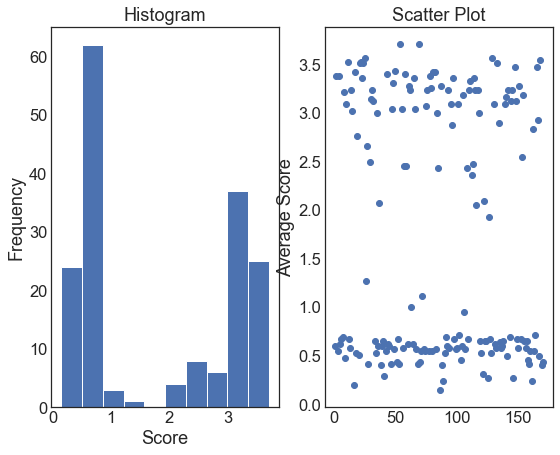

In [471]:
divorces['avg_score'] = divorces.mean(axis=1)
divorces.head()  # now that we dropped our response variable, and added our new average score variable, we take another look

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 7))

ax1.hist(divorces.avg_score)
ax1.set_title('Histogram')
ax1.set_xlabel('Score')
ax1.set_ylabel('Frequency')

ax2.scatter([_ for _ in range(1,171)], divorces.avg_score)
ax2.set_title('Scatter Plot')
ax2.set_ylabel('Average Score')


By looking at this distribution, we can observe and make an assumption that it is probably the low scores that are divorced, and the higher scores that are currently married; but we can't be sure. We will take a closer look at this to see if this is the case.

In [472]:
len(divorces.loc[divorces.avg_score <= 1])

88

In [473]:
len(divorces.loc[divorces.avg_score >= 3])


62

We see that a majority of our couples exist in the `1 and under` score range, and there also exist a strong group in the `3 and over` range as well. We have an extra group of remaining couples which we will observe briefly.

In [474]:
divorces.loc[divorces.avg_score > 1][divorces.avg_score < 3]

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q47,Q48,Q49,Q50,Q51,Q52,Q53,Q54,Divorce,avg_score
75,4,4,3,3,4,0,4,2,4,4,...,4,4,3,4,4,1,1,0,1,2.763636
9,1,1,1,1,1,2,0,2,2,2,...,0,2,2,2,2,4,3,3,1,1.272727
82,4,4,3,4,4,0,0,4,4,4,...,2,3,2,2,2,2,1,2,1,2.654545
76,3,2,4,3,3,2,3,2,2,3,...,0,3,3,3,3,3,3,3,1,2.490909
2,2,2,2,2,1,3,2,1,1,2,...,2,3,1,1,1,2,2,2,1,2.072727
6,3,3,3,2,1,3,4,3,2,2,...,2,3,2,3,3,2,2,2,1,2.454545
78,3,2,4,3,3,2,3,2,2,3,...,0,3,3,3,3,3,3,3,1,2.454545
0,2,2,4,1,0,0,0,0,0,0,...,1,3,3,3,2,3,2,1,1,1.109091
79,4,2,4,2,1,2,3,1,1,3,...,1,3,3,3,3,1,1,1,1,2.436364
73,4,3,3,3,3,1,4,0,4,3,...,3,3,3,3,3,3,3,3,1,2.872727


We can see that these 20 couples are indeed all currently married, which means that our couples are demonstrating a more definitive answer when referring to martial status being `divorced`. There exist couples, which is shown here, that are still married even though there may be slight issues in the relationship, and we would expect to see more of this in-between in a larger sample set, rather than a very strong 'either or' for each.

# Decision Trees

In [475]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth = 3, random_state=42)


pipe = Pipeline([('dtc', dt)])    
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print("Decision Trees")
print("Training sample: ",pipe.score(X_train, y_train))
print("Testing sample:  ",pipe.score(X_test, y_test))

Decision Trees
Training sample:  1.0
Testing sample:   0.9615384615384616


## A quick descent into observing feature importance

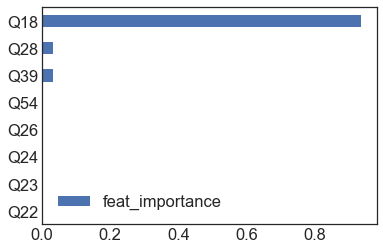

In [476]:
dt_feat = pd.DataFrame(dt.feature_importances_,
                       index=X_train.columns, columns=['feat_importance'])
dt_feat.sort_values('feat_importance').tail(8).plot.barh()
plt.show()


By taking a look at our feature importance, we see something very interesting. Question 18 seems as if it holds a very particular weight to our question set. There are also two other questions, 28 and 39, which represent themselves in this plot as well, which we will list.

- Question 18: My spouse and I have similar ideas about how marriage should be.
- Question 28: I know my spouse's hopes and wishes.
- Question 39: Our discussions often occur suddenly.

It is very logical that the seemingly most important weighing factor into a marriage seems to be the importance of common ideals, as per our feature importance chart.

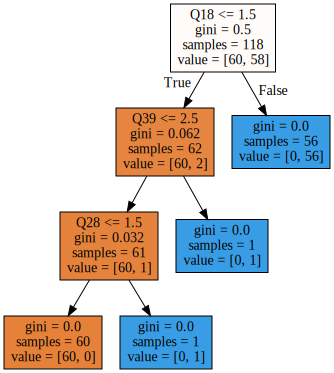

In [477]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from graphviz import Source
from IPython.display import SVG
import os


graph = Source(export_graphviz(dt, out_file=None,
               feature_names=X_train.columns, filled=True))
display(SVG(graph.pipe(format='svg')))


Our actual decision tree is able to show a very clear route to marriage or divorce, but it must be said that a larger amount of samples in the dataset would be likely to give us a much improved version of this.

## Revisiting our Correlation Matrix

Taking a look at these three very highly weighted questions as ascertained by our decision tree, we can revisit our extremely busy correlation matrix from before, and simplify it by viewing just these highly weighted questions to see how they relate to each other.

In [478]:
new_corr =  divorces[['Q39', 'Q18', 'Q28']]
corr = new_corr.corr()
cmap = sns.diverging_palette(5, 250, as_cmap=True)
corr.style.background_gradient(cmap, axis=1).set_properties(**{'max-width': '80px', 'font-size': '10pt'}).set_precision(2)


,Q39,Q18,Q28
Q39,1.00,0.85,0.81
Q18,0.85,1.00,0.84
Q28,0.81,0.84,1.00


Though it might not be a surprise, we can see that all of our coorelation values are very high; all over 0.8, which shows

## Calculating ROC, and Confusion Matrix

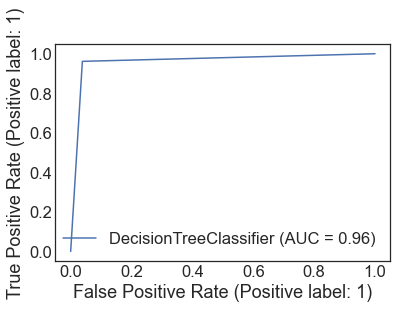

In [479]:
plot_roc_curve(dt, X_test, y_test)

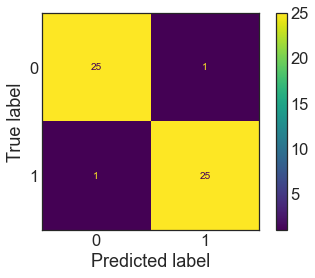

In [480]:
matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=dt.classes_)
disp.plot()
plt.show()


# Random Forest

In [481]:
from sklearn.ensemble import RandomForestClassifier


random_forest = RandomForestClassifier(random_state = 42).fit(X_train, y_train)

pipe = Pipeline([('rf', random_forest)])    
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print("Random Forest")
print("Training sample: ",pipe.score(X_train, y_train))
print("Testing sample:  ",pipe.score(X_test, y_test))


Random Forest
Training sample:  1.0
Testing sample:   0.9807692307692307


## Calculating ROC, and Confusion Matrix

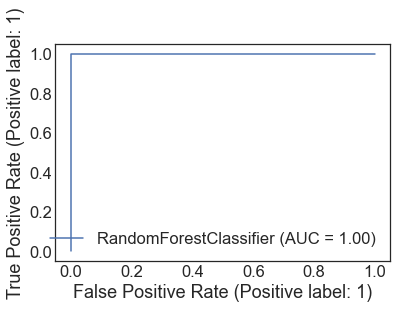

In [482]:
plot_roc_curve(random_forest, X_test, y_test)

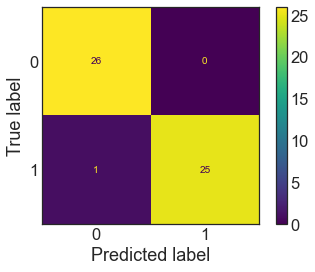

In [483]:
matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=random_forest.classes_)
disp.plot()
plt.show()

# PCA

# Logistic Regression

In [484]:
from sklearn.linear_model import LogisticRegression


logistic_regression = LogisticRegression(random_state = 42)

pipe = Pipeline([('lr', logistic_regression)])    
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print("Logistic Regression")
print("Training sample: ",pipe.score(X_train, y_train))
print("Testing sample:  ",pipe.score(X_test, y_test))


Logistic Regression
Training sample:  1.0
Testing sample:   0.9807692307692307


## Calculating ROC, and Confusion Matrix

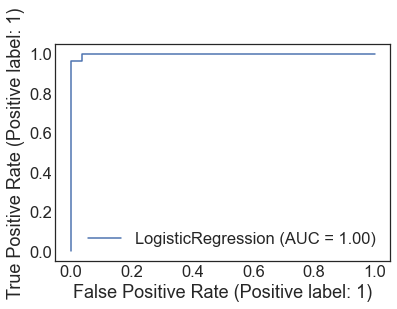

In [485]:
plot_roc_curve(logistic_regression, X_test, y_test)

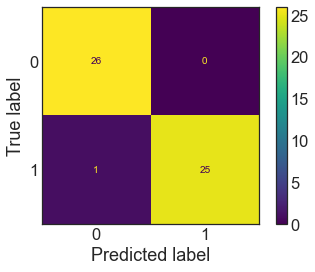

In [486]:
matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=matrix, display_labels=logistic_regression.classes_)
disp.plot()
plt.show()


# Stochastic Gradient Descent

In [487]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(max_iter=1000, tol=0.01)

pipe = Pipeline([('SGD_clf', sgd)])    
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print("Stochastic Gradient Descent")
print("Training sample: ",pipe.score(X_train, y_train))
print("Testing sample:  ",pipe.score(X_test, y_test))


Stochastic Gradient Descent
Training sample:  0.9915254237288136
Testing sample:   0.9807692307692307


## Calculating ROC, and Confusion Matrix

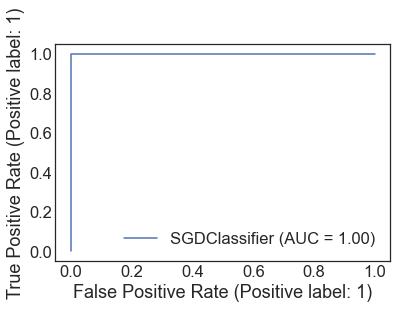

In [488]:
plot_roc_curve(sgd, X_test, y_test)

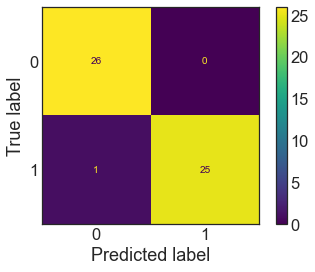

In [489]:
matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=sgd.classes_)
disp.plot()
plt.show()


# Support Vector Machines

In [490]:
from sklearn.svm import SVC

svc = SVC(max_iter=1000, tol=0.01)

pipe = Pipeline([('SVC_clf', svc)])    
pipe.fit(X_train, y_train)
print("Support Vector Machine")
print("Training sample: ",pipe.score(X_train, y_train))
print("Testing sample:  ",pipe.score(X_test, y_test))

Support Vector Machine
Training sample:  0.9830508474576272
Testing sample:   0.9807692307692307


## Calculating AUC, ROC, and Confusion Matrix

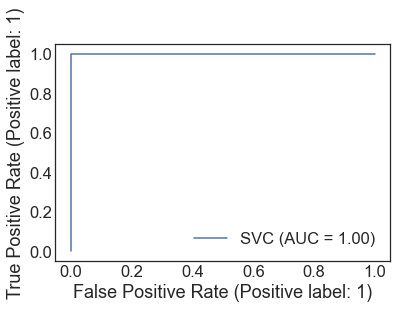

In [491]:
plot_roc_curve(svc, X_test, y_test)

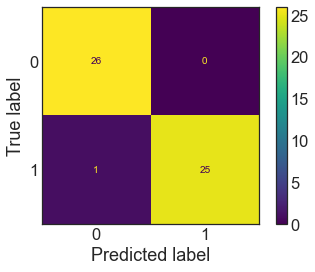

In [492]:
matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=matrix, display_labels=svc.classes_)
disp.plot()
plt.show()


# PCA

In [493]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_tr = scaler.transform(X_train)
X_tr = pd.DataFrame(X_tr, columns = X_train.columns)

X_tr.head()


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q45,Q46,Q47,Q48,Q49,Q50,Q51,Q52,Q53,Q54
0,0.739304,1.567990,0.142284,0.983317,0.924788,-0.796719,0.597377,1.629507,0.358112,0.977100,...,0.352065,1.057305,1.094841,1.159311,1.038416,1.141603,1.266391,1.006155,1.188644,1.171534
1,-1.130079,-0.472703,-1.256838,-0.335222,-0.945926,-0.796719,-0.577465,-0.917272,-0.942109,-0.437597,...,-0.966782,-1.762176,-0.759579,0.253359,-0.300743,-0.283891,-0.340428,-0.950871,-1.420844,-1.181505
2,-1.130079,-1.152934,-1.256838,-0.994491,-0.945926,-0.796719,-0.577465,-0.917272,-0.942109,-0.437597,...,0.352065,-0.352435,-1.377719,-0.652592,-0.300743,-0.283891,-0.340428,-0.298529,-0.116100,-0.004985
3,0.739304,0.887759,0.841845,0.983317,0.924788,0.322481,0.597377,0.992812,1.008222,0.977100,...,0.352065,0.352435,0.476701,0.253359,0.368836,0.428856,0.462982,0.353813,0.536272,0.583275
4,-1.130079,-1.152934,-1.256838,-0.994491,-0.945926,-0.796719,-0.577465,-0.917272,-0.942109,-1.144945,...,0.352065,1.057305,-0.759579,-0.652592,-0.300743,-0.283891,-0.340428,0.353813,-0.116100,-0.004985


In [494]:
X_te = scaler.transform(X_test)
X_te = pd.DataFrame(X_te, columns = X_test.columns)

X_te.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q45,Q46,Q47,Q48,Q49,Q50,Q51,Q52,Q53,Q54
0,1.362431,0.887759,0.841845,0.324048,1.548359,0.322481,-0.577465,0.992812,1.008222,0.269751,...,0.352065,0.352435,1.094841,0.253359,1.038416,1.141603,0.462982,1.006155,0.536272,1.171534
1,0.739304,1.567990,0.841845,0.983317,0.924788,-0.796719,0.597377,1.629507,1.008222,0.977100,...,0.352065,1.057305,0.476701,1.159311,0.368836,0.428856,1.266391,0.353813,1.188644,0.583275
2,-1.130079,-1.152934,-1.256838,-0.994491,-0.945926,-0.796719,-0.577465,-0.917272,-0.942109,-1.144945,...,-0.966782,0.352435,-1.377719,-0.652592,0.368836,0.428856,-0.340428,-0.950871,-1.420844,-1.181505
3,1.362431,0.887759,0.142284,0.983317,1.548359,0.322481,-0.577465,0.992812,0.358112,0.977100,...,0.352065,1.057305,0.476701,1.159311,0.368836,0.428856,1.266391,0.353813,1.188644,0.583275
4,1.362431,0.207528,0.841845,0.324048,1.548359,1.441681,-0.577465,0.356117,1.008222,0.269751,...,1.011489,1.057305,1.094841,1.159311,1.038416,1.141603,1.266391,1.006155,1.188644,1.171534


In [495]:
pca = PCA(n_components=54)
pca.fit(X_tr)

PCA(n_components=54)

In [496]:
pca = PCA(n_components=54)
pca.fit(X_tr)

PCA(n_components=54)

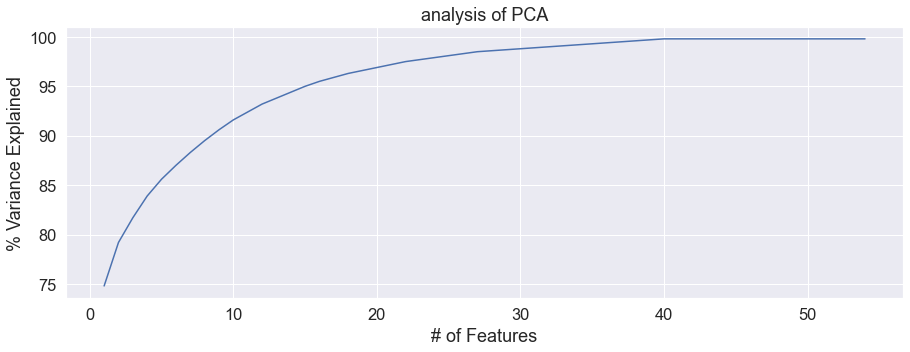

In [497]:
variance = pca.explained_variance_ratio_
var = np.cumsum (np.round (variance, 3) * 100) 

sns.set(font_scale = 1.5)
f, ax = plt.subplots(figsize=(15, 5))
plt.ylabel('% Variance Explained') 
plt.xlabel('# of Features') 
plt.title('analysis of PCA') 
sns.lineplot(x = range(1, 55), y = var);

In [498]:
pca = PCA(n_components = 0.99, svd_solver = 'full') 
pca.fit(X_tr)
pca.n_components_

32

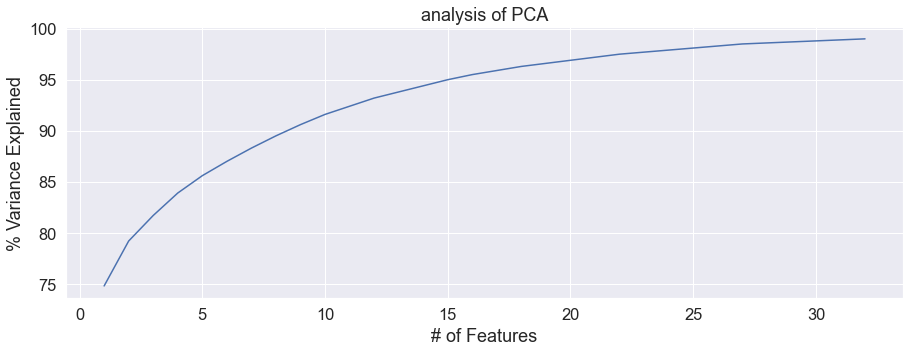

In [499]:
variance2 = pca.explained_variance_ratio_
var2 = np.cumsum (np.round (variance2, 3) * 100) 


sns.set(font_scale = 1.5)
f, ax = plt.subplots(figsize=(15, 5))
plt.ylabel('% Variance Explained') 
plt.xlabel('# of Features') 
plt.title('analysis of PCA') 
sns.lineplot(x = range(1, 33), y = var2);

In [500]:
from sklearn.metrics import roc_auc_score

def get_score(model, X, y, Xt, yt):
  model.fit(X, y)
  y_pred = model.predict_proba(Xt)[:,1]
  score = roc_auc_score(yt, y_pred)
  return score

In [501]:
X_train_pca = pca.transform(X_tr)
X_test_pca  = pca.transform(X_te)

X_train_pca = pd.DataFrame(X_train_pca, columns=[str(i) + ' component' for i in range(1, pca.n_components_ + 1)])
X_test_pca = pd.DataFrame(X_test_pca,  columns=[str(i) + ' component' for i in range(1, pca.n_components_ + 1)])

In [502]:
pca_logreg_score = get_score(logistic_regression, X_train_pca, y_train, X_test_pca, y_test)
print('AUC score for Logistic Regression:', pca_logreg_score)

AUC score for Logistic Regression: 0.9985207100591716


In [503]:
pca_rforest_score = get_score(random_forest, X_train_pca, y_train, X_test_pca, y_test)
print('AUC score for Random Forest:', pca_rforest_score)

AUC score for Random Forest: 1.0


# Executive Summary

The data source for this project is the UCI (University of California Irvine) Repository, which  provides a wide range of datasets for students, educators, and researchers interested in Machine Learning. The Divorce Predictors Data Set is sourced by a collection of professors at various universities. The Divorce Predictors dataset itself consists of data coming from 150 Turkish couples; 84 divorced, and 86 currently married, who completed an assessment aimed at getting a basic understanding of the couple, and their relationship. The data has 170 instances, containing 54 predictors in the form of written questions. These predictors are then divided into a 0 - 5 scale where 0 corresponds to never, 1 corresponds to seldom, 2 corresponds to an average amount, 3 means frequently, and 4 indicates always.
	Several questions were asked, the key ones being what predictors were most likely to lead to a divorce, and what responses tended to be the most popular. Several models were also run in order to attempt to accurately predict the likelihood of a divorce using a testing and training set. Our key results showed that couples tended to be very radical in their responses. For example, they rarely replied that they were neutral and instead often agreed and/or disagreed with the question. Another key result is that using a testing and training set, a machine learning algorithm could be made to classify the data which approached 100% accuracy. In this case, the algorithm that did the best job was stochastic gradient descent, however other algorithms also approached 100% accuracy. Question 18 proved to be the most key contributor to many of the models. This stated that the couple had “similar ideas about how marriage should be.”
	Our first key proposal is that marriages should be avoided if the couple does not have similar ideas about how a marriage should be or cannot compromise effectively. This directly correlates to the result showing question 18 being a key predictor of whether a marriage culminated in a divorce. Question 28 and 39 also proved to be key predictors although to a much lesser extent. They respectively were coordinated with “I know my spouse’s hopes and wishes” and “our discussions often occur suddenly”. There also was a much more demonstrated bias towards radical (agree/disagree) responses by people who were divorced as opposed to those who were neutral.